In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.validation import _check_large_sparse
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [3]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Edit the cell below to load another dataset or combine them together.

In [4]:
# Reading NA data
X_df = pd.read_csv('../new_data/NA/na_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/NA/na_labels_cleaned.csv', usecols=['filename', 'emotions'], index_col='filename')
# Reading Persian data
# X_df_p = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
# Y_df_p = pd.read_csv('../new_data/Persian/p_labels_cleaned.csv', usecols=['filename', 'emotions'], index_col='filename')

# concatenate them
# Y_df = pd.concat([Y_df_na, Y_df_p], sort=False)
# X_df = pd.concat([X_df_na, X_df_p], ignore_index=True, sort=False)


In [5]:
# Remove videos that we deleted from labels.
X_df = X_df[X_df['filename'].isin(Y_df.index)]
# Reset index to prevent future errors in using iloc
X_df.reset_index(inplace=True, drop=True)
# Change emotion column to list type
Y_df["emotions"] = Y_df["emotions"].apply(eval)

label_cols = to_1D(Y_df["emotions"]).unique() 
labels_expanded = boolean_df(Y_df['emotions'], label_cols )


In [6]:
X_df['none']  = np.NaN
X_df['furious']  = np.NaN
X_df['anger']  = np.NaN
X_df['annoyed']  = np.NaN
X_df['contempt']  = np.NaN
X_df['hatred']  = np.NaN


In [ ]:
X_df.head()

In [7]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
    X_df.at[index,'none'] = labels_expanded.at[filename,'none']
    X_df.at[index,'furious'] = labels_expanded.at[filename,'furious']
    X_df.at[index,'anger'] = labels_expanded.at[filename,'anger']
    X_df.at[index,'annoyed'] = labels_expanded.at[filename,'annoyed']
    X_df.at[index,'contempt'] = labels_expanded.at[filename,'contempt']
    X_df.at[index,'hatred'] = labels_expanded.at[filename,'hatred']

## Ablation Studies
Run the cell below to remove columns for ablation studies and then run the training cell.

In [ ]:
## Ablation cols
# ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']
ablation_cols = ['pose_Rx','pose_Ry','pose_Rz','gaze_angle_x','gaze_angle_y']

In [ ]:
X_df = X_df.drop(columns=ablation_cols)
X_df

### Min-Max Scaling
To limit the scale of features

In [8]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success', 'none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred'])
)
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test
Randomly select 25% of videos apart for testing.

In [9]:
videos = X_df['filename'].unique()
# Comment this line and uncomment next to test on Persian videos
test_videos = ['na/vid_13.mp4', 'na/vid_92.mp4', 'na/vid_93.mp4', 'na/vid_6.mp4', 'na/vid_14.mp4', 'na/vid_10_1.mp4', 'na/vid_34.mp4', 'na/vid_86.mp4', 'na/vid_83.mp4', 'na/vid_90.mp4', 'na/vid_60.mp4', 'na/vid_24.mp4', 'na/vid_10_3.mp4', 'na/vid_10_2.mp4', 'na/vid_87.mp4', 'na/vid_32.mp4', 'na/vid_79.mp4', 'na/vid_68.mp4', 'na/vid_56.mp4', 'na/vid_36.mp4']
# test_videos = ['persian/vid_59.mp4', 'persian/vid_79.mp4', 'persian/vid_40.mp4', 'persian/vid_10.mp4', 'persian/vid_1.mp4', 'persian/vid_5.mp4', 'persian/vid_44.mp4', 'persian/vid_85.mp4', 'persian/vid_25.mp4', 'persian/vid_75.mp4', 'persian/vid_66.mp4', 'persian/vid_50.mp4', 'persian/vid_81.mp4', 'persian/vid_60.mp4', 'persian/vid_87.mp4', 'persian/vid_90.mp4', 'persian/vid_35.mp4', 'persian/vid_37.mp4', 'persian/vid_42.mp4', 'persian/vid_69.mp4', 'persian/vid_70.mp4', 'persian/vid_52.mp4', 'persian/vid_53.mp4', 'persian/vid_82.mp4'])
# print(test_videos.to_list())

In [10]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
label_cols = ['none', 'furious', 'anger', 'annoyed', 'contempt', 'hatred']

print(X_df.head())

train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
metadata_test.reset_index(inplace=True)
y_test = test_df[label_cols].values
X_test = test_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values

       filename         culture  frame  face_id  timestamp  confidence  \
0  na/vid_1.mp4  north american      1        0      0.000        0.98   
1  na/vid_1.mp4  north american      2        0      0.017        0.98   
2  na/vid_1.mp4  north american      3        0      0.033        0.98   
3  na/vid_1.mp4  north american      4        0      0.050        0.98   
4  na/vid_1.mp4  north american      5        0      0.067        0.98   

   success    AU01_r  AU02_r  AU04_r  ...   pose_Ry   pose_Rz  gaze_angle_x  \
0        1  0.386667   0.372     0.0  ...  0.549242  0.241562      0.527431   
1        1  0.400000   0.396     0.0  ...  0.551136  0.241080      0.524172   
2        1  0.418667   0.396     0.0  ...  0.551136  0.240598      0.523628   
3        1  0.416000   0.398     0.0  ...  0.551136  0.240598      0.523628   
4        1  0.373333   0.388     0.0  ...  0.554545  0.235776      0.519826   

   gaze_angle_y  none  furious  anger  annoyed  contempt  hatred  
0      0.7007

In [10]:
len(X_test)


4122

In [ ]:
y_test[800:805,:]


In [ ]:
metadata_test.iloc[800:805]

## Training with Cross-validation

### Classifier Chain
Choose one of the classifiers for CC: base_knn, base_xgb

In [11]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier


kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
# metadata_test.reset_index(inplace=True)

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_xgb = XGBClassifier(objective="binary:logistic", learning_rate=0.2, eval_metric='logloss')
    base_rf = RandomForestClassifier()

    # ovr = MultiOutputClassifier(base_xgb)
    # ovr.fit(X_train, y_train)
    # valid_pred_ovr = ovr.predict(X_valid)
    # ovr_jaccard_score = jaccard_score(y_valid, valid_pred_ovr, average='samples')
    # ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_ovr)
    # print("One-vs-Rest validation Jaccard score:" , ovr_jaccard_score)
    # print("One-vs-Rest validation Hamming loss: " , ovr_ham_loss)

   
    # Y_pred_ovr = ovr.predict(X_test)
    # a = jaccard_score(y_test, Y_pred_ovr, average='samples')
    # b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # # print(Y_pred_ovr[800:805,:])
    # # print(y_test[800:805,:])

    # print("One-vs-Rest test Jaccard score: ", a)
    # print("One-vs-Rest test Hamming loss: " , b)
    
    
    chains = [ClassifierChain(base_knn, order='random', random_state=0) for i in range(7)]
    best_model_index = 0
    best_jac = 0            
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        if val_score > best_jac:
            best_model_index = j
            best_jac = val_score
            
        
    # predict on validation data
    valid_pred_chains = chains[best_model_index].predict(X_valid)
    chain_jaccard_scores = jaccard_score(y_valid, valid_pred_chains >= .5,
                                    average='samples')

    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =metrics.hamming_loss(y_valid, valid_pred_chains >= .5)
                
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = chains[best_model_index].predict(X_test)
    chain_jaccard_scores = jaccard_score(y_test, Y_pred_chains >= .5,
                                    average='samples')
                    

    # chain01_scores = [metrics.zero_one_loss(y_test, Y_pred_chain) for Y_pred_chain in Y_pred_chains]

    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_test, Y_pred_chains) 
                
    frames_mean_hm_test.append(np.mean(chain_hamming_loss))
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains, columns=label_cols)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[label_cols].sum()
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        # ##### TODO: Bug is somewhere here:
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)


1-th split: train: 44, test: 12
['na/vid_62.mp4' 'na/vid_61.mp4' 'na/vid_76.mp4' 'na/vid_2.mp4'
 'na/vid_72.mp4' 'na/vid_80.mp4' 'na/vid_85.mp4' 'na/vid_27.mp4'
 'na/vid_84.mp4' 'na/vid_69.mp4' 'na/vid_81.mp4' 'na/vid_29.mp4'
 'na/vid_8.mp4' 'na/vid_1.mp4' 'na/vid_35.mp4' 'na/vid_5.mp4'
 'na/vid_70.mp4' 'na/vid_11.mp4' 'na/vid_21.mp4' 'na/vid_17.mp4'
 'na/vid_4.mp4' 'na/vid_88.mp4' 'na/vid_19.mp4' 'na/vid_9.mp4'
 'na/vid_95.mp4' 'na/vid_67.mp4' 'na/vid_66.mp4' 'na/vid_73.mp4'
 'na/vid_101.mp4' 'na/vid_12.mp4' 'na/vid_22.mp4' 'na/vid_82.mp4'
 'na/vid_74.mp4' 'na/vid_3.mp4' 'na/vid_15.mp4' 'na/vid_26.mp4'
 'na/vid_30.mp4' 'na/vid_65.mp4' 'na/vid_100.mp4' 'na/vid_23.mp4'
 'na/vid_77.mp4' 'na/vid_18.mp4' 'na/vid_37.mp4' 'na/vid_89.mp4']
Training+validation data size:  3081
Training data size:  3081
Validation data size:  1319
CC Validation Jaccard Score:
  0.2930250189537528
CC Validation Hamming Loss:
  0.26396259792772303
CC Test Jaccard Score: 
  0.3252126836813612
CC Test Hamming Loss:

## Classification Report

In [12]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(y_test, Y_pred_chains, target_names=label_cols))
print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, target_names=label_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.24      0.38      0.29       129
     furious       0.17      0.59      0.27        54
       anger       0.58      0.25      0.35       416
     annoyed       0.65      0.62      0.63       658
    contempt       0.22      0.22      0.22       204
      hatred       0.00      0.00      0.00         0

   micro avg       0.45      0.44      0.44      1461
   macro avg       0.31      0.34      0.29      1461
weighted avg       0.52      0.44      0.45      1461
 samples avg       0.46      0.45      0.45      1461

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.00      0.00      0.00         3
     furious       0.33      1.00      0.50         1
       anger       1.00      0.38      0.55         8
     annoyed       0.40      0.67      0.50         6
    contempt       0.25   

In [13]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(y_test, Y_pred_chains, average='samples'))
print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, average='samples'))

------------------- Frame-level Jaccard -----------------
0.4309100283578242
------------------- Video-level Jaccard -----------------
0.3684210526315789


Print average of metrics


In [15]:
print("F-jac: ", np.mean(frames_mean_jac_test))
print("V-jac: ", np.mean(videos_mean_jac_test))
print("F-ham: ", np.mean(frames_mean_hm_test))
print("V-ham: ", np.mean(videos_mean_hm_test))

F-jac:  0.3022626556687692
V-jac:  0.35457364341085273
F-ham:  0.2858563803978651
V-ham:  0.2527131782945736


In [14]:
videos_mean_jac_test

[0.27596899224806204,
 0.4069767441860465,
 0.39922480620155043,
 0.36124031007751944,
 0.3294573643410853]

In [ ]:
print(test_videos.to_list())

## Confused frames
The cell below finds frames that are misclassified

In [14]:

# Confusions
confused = 0
for i,_ in enumerate(y_test):
    if np.subtract(y_test[i], test_result_df.iloc[i][label_cols].to_numpy(dtype=int)).sum() != 0.0:
        confused += 1
        print(metadata_test.iloc[i], "------- Actual: ", y_test[i], " ----- pred: ", Y_pred_chains[i])
print("confused: ", confused)

id_68.mp4
timestamp             0.801
Name: 900, dtype: object ------- Actual:  [0. 0. 1. 0. 0. 0.]  ----- pred:  [0. 0. 1. 0. 0. 1.]
index                  3269
frame                    29
face_id                   0
culture      north american
filename      na/vid_68.mp4
timestamp             0.934
Name: 904, dtype: object ------- Actual:  [0. 0. 1. 0. 0. 0.]  ----- pred:  [0. 0. 1. 0. 0. 1.]
index                  3270
frame                    30
face_id                   0
culture      north american
filename      na/vid_68.mp4
timestamp             0.968
Name: 905, dtype: object ------- Actual:  [0. 0. 1. 0. 0. 0.]  ----- pred:  [0. 0. 1. 0. 0. 1.]
index                  3275
frame                    35
face_id                   0
culture      north american
filename      na/vid_68.mp4
timestamp             1.134
Name: 910, dtype: object ------- Actual:  [0. 0. 1. 0. 0. 0.]  ----- pred:  [0. 0. 0. 1. 1. 0.]
index                  3276
frame                    36
face_id           

In [ ]:
print("F-jac: ", np.mean(frames_mean_jac_test))
print("V-jac: ", np.mean(videos_mean_jac_test))
print("F-ham: ", np.mean(frames_mean_hm_test))
print("V-ham: ", np.mean(videos_mean_hm_test))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.0, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

### ML KNN

In [15]:
from skmultilearn.adapt import MLkNN, MLTSVM
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']+ label_cols).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    # print("^^^^^^^^", y_test_pred.toarray().shape)
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 44, validation: 12
Training+validation data size:  3081
Training data size:  3081
Validation data size:  1319
Validation Hamming Loss:
  0.262446297700278
Test Hamming Loss:
  0.2529002320185615
Test Jaccard Score:
  0.3066511987625677
2-th split: train: 45, validation: 11
Training+validation data size:  3540
Training data size:  3540
Validation data size:  860
Validation Hamming Loss:
  0.24844961240310076
Test Hamming Loss:
  0.22621809744779584
Test Jaccard Score:
  0.32018561484918795
3-th split: train: 45, validation: 11
Training+validation data size:  3675
Training data size:  3675
Validation data size:  725
Validation Hamming Loss:
  0.23195402298850576
Test Hamming Loss:
  0.18922402681103379
Test Jaccard Score:
  0.40551688579530804
4-th split: train: 45, validation: 11
Training+validation data size:  3760
Training data size:  3760
Validation data size:  640
Validation Hamming Loss:
  0.22838541666666667
Test Hamming Loss:
  0.2003093580819799
Test Jaccard S

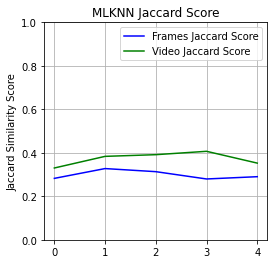

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.00, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

In [18]:
print("F-jac: ", np.mean(frames_mean_jac_test))
print("V-jac: ", np.mean(videos_mean_jac_test))
print("F-ham: ", np.mean(frames_mean_hm_test))
print("V-ham: ", np.mean(videos_mean_hm_test))


F-jac:  0.29868429564936116
V-jac:  0.3730232558139535
F-ham:  0.26759663593724725
V-ham:  0.24341085271317828


In [ ]:
videos_mean_jac_test

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.mean(frames_mean_hm_test)

In [ ]:
train_df.head()

Multilabel confusion matrix puts TN at (0,0) and TP at (1,1) position thanks @Kenneth Witham for pointing out.


`support`: The number of occurrences of each label in y_true.

In [16]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(y_test, y_test_pred, target_names=label_cols))

print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, target_names=label_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.25      0.26      0.26       129
     furious       0.25      0.54      0.34        54
       anger       0.58      0.41      0.48       416
     annoyed       0.68      0.62      0.65       658
    contempt       0.24      0.22      0.23       204
      hatred       0.00      0.00      0.00         0

   micro avg       0.51      0.47      0.49      1461
   macro avg       0.33      0.34      0.33      1461
weighted avg       0.54      0.47      0.50      1461
 samples avg       0.48      0.49      0.47      1461

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.00      0.00      0.00         3
     furious       0.50      1.00      0.67         1
       anger       0.80      0.50      0.62         8
     annoyed       0.44      0.67      0.53         6
    contempt       0.25   

In [20]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(y_test, y_test_pred, average='samples'))

print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, average='samples'))

------------------- Frame-level Jaccard -----------------
0.2902434093482128
------------------- Video-level Jaccard -----------------
0.35271317829457366


In [ ]:
print(type(y_test[0]))
print(type(y_test_pred[0].toarray()))
for i in range(len(y_test)):
    if metrics.hamming_loss(y_test[i].flatten(), Y_pred_chains[4][i].flatten()) > 0:
        print("Ground Truth: ", y_test[i], ", Prediction: ", Y_pred_chains[0][i])
        print("Video data: ", metadata_test.iloc[i])

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)